In [1]:
from numba import float64, boolean, types, int16
from numba.experimental import jitclass
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [2]:
import numpy as np

class Module():
    def __init__(self) -> None:
        self._runtime: float = 0.0
        self._remaining_maintenance_time: float = 0.0
        self._time_since_last_maintenance: float = 0.0
        self._under_maintenance: bool = False
        self._total_maintenance_time: float = 0.0
        self._maintenance_cost_per_hour: float = 0.0
        self._maintenance_time_on_failure: float = 0.0
        self._load: float = 0.0

    @property
    def Runtime(self) -> float:
        return self._runtime

    @property
    def Load(self) -> float:
        return self._load

    @Load.setter
    def Load(self, value: float) -> None:
        self._load = value

    @property
    def maintenancecostperhour(self) -> float:
        return self._maintenance_cost_per_hour

    @property
    def TotalMaintenanceTime(self) -> float:
        return self._total_maintenance_time

    @TotalMaintenanceTime.setter
    def TotalMaintenanceTime(self, value: float) -> None:
        self._total_maintenance_time = value

    @property
    def RemainingMaintenanceTime(self) -> float:
        return self._remaining_maintenance_time

    @RemainingMaintenanceTime.setter
    def RemainingMaintenanceTime(self, value: float) -> None:
        self._remaining_maintenance_time = value
        if self._remaining_maintenance_time <= 0:
            self._remaining_maintenance_time = 0
            self._under_maintenance = False
            self._time_since_last_maintenance = 0.0
        else:
            self._under_maintenance = True

    @property
    def TimeSinceLastMaintenance(self) -> float:
        return self._time_since_last_maintenance

    @property
    def UnderMaintenance(self) -> bool:
        return self._under_maintenance

    @UnderMaintenance.setter
    def UnderMaintenance(self, value: bool) -> None:
        self._under_maintenance = value

    @property
    def Products(self) -> np.ndarray:
        return self._products

    @property
    def Consumption(self) -> np.ndarray:
        return self._consumption

    @property
    def CapeX(self) -> float:
        """
        Returns the capital expenditure of the module.
        """
        pass
    
    @property
    def Opex(self) -> float:
        """
        Returns the operational expenditure of the module.
        """
        pass

    def _check_failure(self) -> bool:
        """
        Checks if the module has failed.
        Returns:
            failed: bool, True if the module has failed, False otherwise
        """
        pass

    def _produce(self, time_delta: float) -> np.ndarray:
        """
        Produces energy based on the load and time delta.
        Arguments:
            load: float, load as a value between 0 and 1
        Returns:
            products: list, list of products produced by the module
        """
        pass

    def _consume(self, time_delta: float) -> np.ndarray:
        """
        Consumes energy based on the load and time delta.
        Arguments:
            load: float, load as a value between 0 and 1
        Returns:
            products: list, list of products consumed by the module
        """
        pass

    def _maintain(self, time_delta: float):
        """
        Maintains the module based on the time delta.
        Arguments:
            time_delta: float, time difference in hours
        """
        self.RemainingMaintenanceTime -= time_delta

    def _calculate_maintenance_time(self) -> float:
        """
        Calculates the maintenance time of the module.
        Returns:
            maintenance_time: float, maintenance time in hours
        """
        pass

    def report_status(self) -> np.ndarray:
        """
        Reports the status of the module.
        Returns:
            status: list, list of status parameters
        """
        status = [
            self._load,
            self._remaining_maintenance_time,
            *self._products,
            *self._consumption,
        ]
        return np.array(status)

    def step(self, time_delta: float):
        """
        Updates the module based on the load and time delta.
        Arguments:
            load: float, load as a value between 0 and 1
            time_delta: float, time difference in hours
        """
        if not self._under_maintenance:
            if self._check_failure():
                self.RemainingMaintenanceTime = self._calculate_maintenance_time()
                self._total_maintenance_time += self.RemainingMaintenanceTime
                self._maintain(time_delta)
                self._products = np.zeros_like(self._products)
                self._consumption = np.zeros_like(self._consumption)
            else:
                self._time_since_last_maintenance += time_delta
                self._runtime += time_delta
                self._products = self._produce(time_delta)
                self._consumption = self._consume(time_delta)
        else:
            self._maintain(time_delta)
            self._products = np.zeros_like(self._products)
            self._consumption =np.zeros_like(self._consumption)


In [3]:
@jitclass(spec=[
    # ============ Module ============
    ('_runtime', float64),
    ('_remaining_maintenance_time', float64),
    ('_products', float64[:]),
    ('_consumption', float64[:]),
    ('_time_since_last_maintenance', float64),
    ('_total_maintenance_time', float64),
    ('_maintenance_time_on_failure', float64),
    ('_maintenance_cost_per_hour', float64),
    ('_under_maintenance', boolean),
    ('_load', float64),
    # ============ Boiler ============
    ('max_output_capacity', float64),
    ('efficiency_rules', float64[:,:]),
    ('stepless_bounds', float64[:,:]),
    ('power_output_with_efficiency', float64[:]),
    ('power_output_with_loads', float64[:]),
    ('maintenance_time_on_failure', float64),
    ('maintenance_cost_per_hour', float64),
    ('capex_sp', float64),
])
class Boiler(Module):
    
    def __init__(self, max_output_capacity: float, efficiency_rules: np.ndarray, stepless_bounds: np.ndarray,\
                  maintenance_time_on_failure: float, \
				  maintenance_cost_per_hour: float,\
                  capex_sp:float):

        self.max_output_capacity = max_output_capacity
        self.efficiency_rules = efficiency_rules
        self.stepless_bounds = stepless_bounds
        self._maintenance_time_on_failure = maintenance_time_on_failure
        self._maintenance_cost_per_hour = maintenance_cost_per_hour
        self.capex_sp = capex_sp

        self.power_output_with_efficiency = self.efficiency_rules[:, 1] * self.max_output_capacity
        self.power_output_with_loads = self.efficiency_rules[:, 0] * self.power_output_with_efficiency

    def calculate_load(self, power_demand):
        if power_demand == 0:
            return 0
        elif power_demand > self.max_output_capacity:
            return 1
        else:
            closest_rule = np.argmin(np.abs(self.power_output_with_loads - power_demand))
            for bound in self.stepless_bounds:
                if bound[0] <= self.efficiency_rules[closest_rule, 0] <= bound[1]:
                    return power_demand / self.power_output_with_efficiency[closest_rule]
            return self.efficiency_rules[closest_rule, 0]

    def _produce(self, time_delta: float) -> np.ndarray:
        closest_rule = np.argmin(np.abs(self.efficiency_rules[:, 0] - self.Load))
        return np.array([time_delta * self.Load * self.power_output_with_efficiency[closest_rule]])

    def _consume(self, time_delta: float) -> np.ndarray:
        return np.array([time_delta * self.Load * self.max_output_capacity / 200])

    def _calculate_maintenance_time(self) -> float:
        return self._maintenance_time_on_failure

    def _check_failure(self) -> bool:
        return self.TimeSinceLastMaintenance > 1000

## Economic calculation
	# Annual cost calculation
    def maintenance_cost(self):
        return self._maintenance_cost_per_hour * self.TotalMaintenanceTime

    def debt_payment(self):
        debt_ratio = 1
        bank_interest_rate = 0.05
        payback_time = 10
        return self.capex_sp * debt_ratio * ( bank_interest_rate )* 1/(1-1/(1+bank_interest_rate)**(payback_time))
        
    def total_annual_cost(self):
        return self.maintenance_cost()

In [4]:
efficiency_rules = np.array([
    [0.0, 0.0],
    [0.1, 0.4],
    [0.2, 0.6],
    [0.8, 0.8],
    [1.0, 1.0]
])

stepless_bounds = np.array([
    [0.0, 0.1],
    [0.8, 1.0]
])

In [5]:
b = Boiler(100., efficiency_rules, stepless_bounds, 72., 100., 0.2)

In [6]:
b.Load = 0.8

In [7]:
status = np.zeros((24 * 365 * 4 * 10, 4))
annual_costs = np.zeros((10, 1))
annual_debts = np.zeros((10, 1))
base_cost = 0
total = np.zeros((10, 1))
for i in range(24 * 365 * 4 * 10):
    b.Load = np.random.uniform(0, 1)
    b.step(0.25)
    status[i] = b.report_status()
    if (i == (24 * 365 * 4)):
        base_cost = b.total_annual_cost()
    if((i % (24*365*4)) == 0):
        r = np.random.uniform(0.1, 0.5)
        debp_payment = b.debt_payment()
        cost = base_cost * (1 + r)
        annual_costs[int(i / (24 * 365 * 4))] = cost
        annual_debts[int(i / (24 * 365 * 4))] = debp_payment
        total[int(i / (24 * 365 * 4))] = cost+debp_payment
        print(f"{cost=}\t{debp_payment=}\ttotal={cost+debp_payment}")
        b.TotalMaintenanceTime = 0
    

cost=0.0	debp_payment=0.02590091499309134	total=0.02590091499309134
cost=69630.97537952274	debp_payment=0.02590091499309134	total=69631.00128043773
cost=72890.93847905581	debp_payment=0.02590091499309134	total=72890.9643799708
cost=76728.41073571984	debp_payment=0.02590091499309134	total=76728.43663663483
cost=71677.56180425607	debp_payment=0.02590091499309134	total=71677.58770517106
cost=64650.51145137846	debp_payment=0.02590091499309134	total=64650.53735229345
cost=90653.51800347312	debp_payment=0.02590091499309134	total=90653.5439043881
cost=68088.4970653706	debp_payment=0.02590091499309134	total=68088.52296628559
cost=75010.71976971887	debp_payment=0.02590091499309134	total=75010.74567063386
cost=74623.08514233821	debp_payment=0.02590091499309134	total=74623.1110432532


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

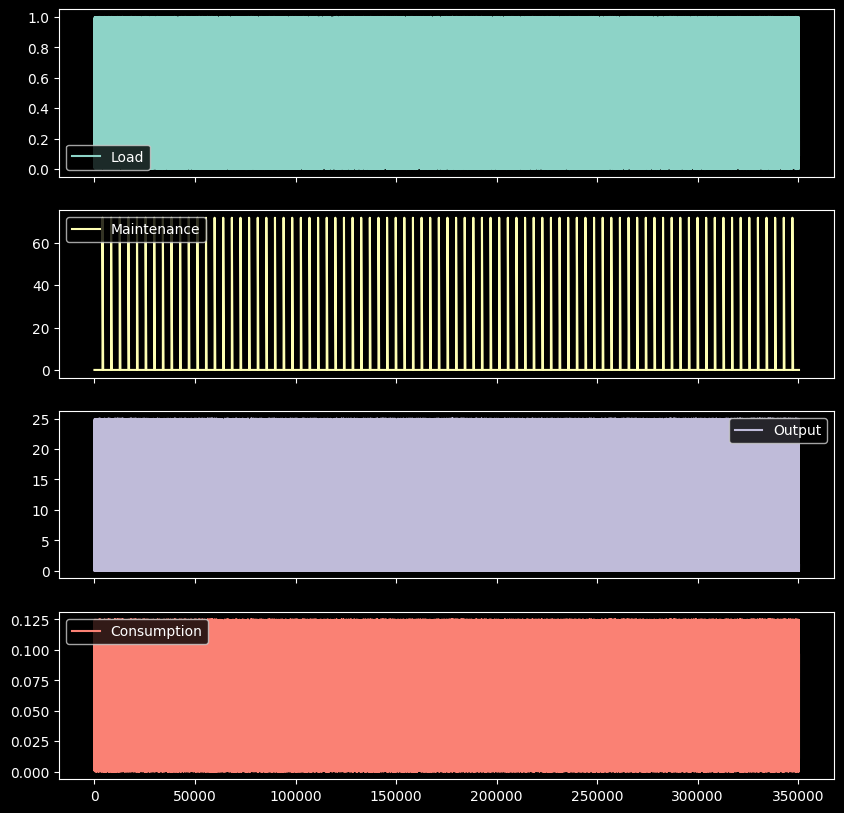

In [8]:
data = pd.DataFrame(status, columns=['Load', 'Maintenance', 'Output', 'Consumption'])
data.plot(subplots=True, figsize=(10, 10))

<AxesSubplot: >

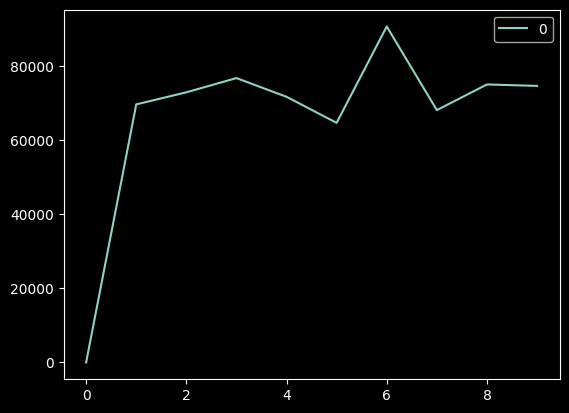

In [9]:
sns.lineplot(annual_costs)

<AxesSubplot: >

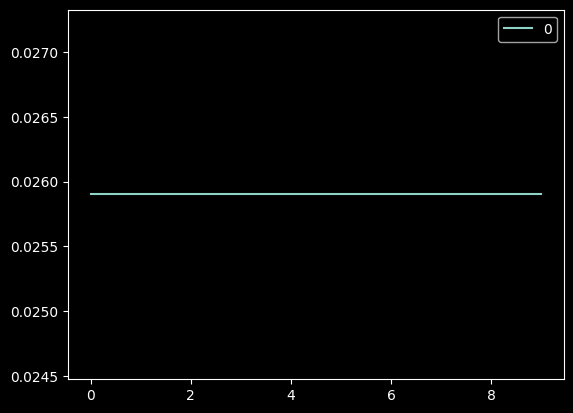

In [10]:
sns.lineplot(annual_debts)

<AxesSubplot: >

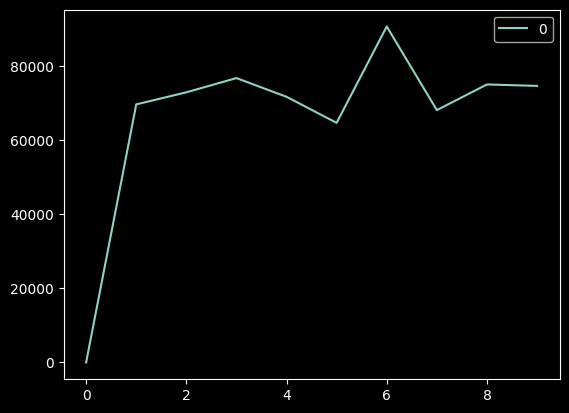

In [11]:
sns.lineplot(total)